# Weight Noise: Clip at Zero, Affine Rescale to Match Mean and Std

Goal: Apply multiplicative noise with clip at 0 only (no upper bound), then use an affine transformation to exactly match the original mean and std of non-zero weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100

In [2]:
# Load example weights
convexity_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/feedforward-noisy-units-convexity-check"
)
example_run_dir = convexity_dir / "convexity-check-seed-42"

teacher_data = np.load(example_run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data["feedforward_weights"]
teacher_rec_weights = teacher_data["recurrent_weights"]
weights = np.concatenate([teacher_ff_weights, teacher_rec_weights], axis=0)

# Get non-zero weights only
nonzero_mask = weights != 0
weights_nz = weights[nonzero_mask]

print(f"Total weights: {weights.size:,}")
print(f"Non-zero weights: {weights_nz.size:,}")
print(f"Sparsity: {100 * (1 - weights_nz.size / weights.size):.1f}%")

Total weights: 32,500,000
Non-zero weights: 1,852,500
Sparsity: 94.3%


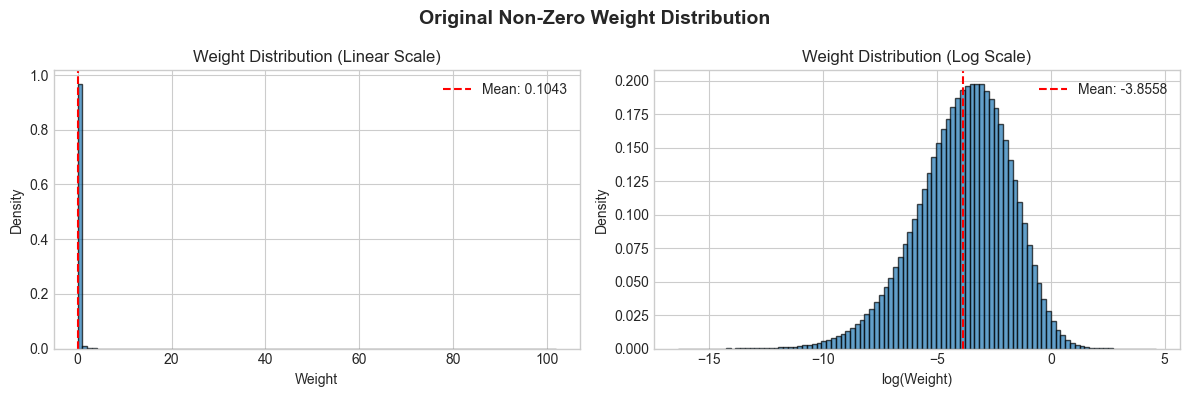


Original non-zero weight statistics:
  Mean: 0.104253
  Std:  0.325422


In [3]:
# Visualize the original weight distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(weights_nz, bins=100, density=True, alpha=0.7, edgecolor='black')
ax.axvline(weights_nz.mean(), color='red', linestyle='--', label=f'Mean: {weights_nz.mean():.4f}')
ax.set_xlabel("Weight")
ax.set_ylabel("Density")
ax.set_title("Weight Distribution (Linear Scale)")
ax.legend()

ax = axes[1]
log_weights = np.log(weights_nz)
ax.hist(log_weights, bins=100, density=True, alpha=0.7, edgecolor='black')
ax.axvline(log_weights.mean(), color='red', linestyle='--', label=f'Mean: {log_weights.mean():.4f}')
ax.set_xlabel("log(Weight)")
ax.set_ylabel("Density")
ax.set_title("Weight Distribution (Log Scale)")
ax.legend()

plt.suptitle("Original Non-Zero Weight Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nOriginal non-zero weight statistics:")
print(f"  Mean: {weights_nz.mean():.6f}")
print(f"  Std:  {weights_nz.std():.6f}")

In [4]:
# The noise function: clip at 0, then affine transform to match mean and std

def apply_noise_affine(weights, noise_frac, rng, verbose=False):
    """
    Apply multiplicative noise clipped at 0, then affine transform to match original mean and std.
    
    Steps:
    1. Apply multiplicative noise: w * max(1 + noise_frac * N(0,1), 0)
    2. Compute original and noisy statistics on non-zero weights
    3. Affine transform: new = orig_mean + (noisy - noisy_mean) * (orig_std / noisy_std)
    """
    nonzero_mask = weights != 0
    
    # Original statistics (non-zero only)
    orig_mean = weights[nonzero_mask].mean()
    orig_std = weights[nonzero_mask].std()
    
    # Apply multiplicative noise, clip at 0 only
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.maximum(multiplier, 0)
    noisy = weights * multiplier
    
    # Noisy statistics (non-zero positions only) BEFORE rescaling
    noisy_nz = noisy[nonzero_mask]
    noisy_mean = noisy_nz.mean()
    noisy_std = noisy_nz.std()
    
    if verbose:
        print("Before affine transformation:")
        print(f"  Original: mean={orig_mean:.6f}, std={orig_std:.6f}")
        print(f"  Noisy:    mean={noisy_mean:.6f}, std={noisy_std:.6f}")
        print(f"  Scale factor: {orig_std / noisy_std:.6f}")
    
    # Affine transform to match original mean and std
    # new = orig_mean + (old - old_mean) * (orig_std / old_std)
    if noisy_std > 0:
        noisy[nonzero_mask] = orig_mean + (noisy_nz - noisy_mean) * (orig_std / noisy_std)
    
    if verbose:
        final_nz = noisy[nonzero_mask]
        print("\nAfter affine transformation:")
        print(f"  Final:    mean={final_nz.mean():.6f}, std={final_nz.std():.6f}")
        print(f"  Match? mean={np.isclose(final_nz.mean(), orig_mean)}, std={np.isclose(final_nz.std(), orig_std)}")
    
    return noisy


# Test it with verbose output
noise_frac = 0.4
seed = 42
rng = np.random.default_rng(seed)

print("=" * 60)
print("Testing apply_noise_affine with verbose=True")
print("=" * 60)
noisy_weights = apply_noise_affine(weights.copy(), noise_frac, rng, verbose=True)
noisy_nz = noisy_weights[nonzero_mask]

print("\n" + "=" * 60)
print("Final statistics comparison (non-zero weights):")
print("=" * 60)
print(f"{'':15} {'Original':>15} {'Noisy':>15} {'Diff':>15}")
print("-" * 60)
mean_diff = noisy_nz.mean() - weights_nz.mean()
std_diff = noisy_nz.std() - weights_nz.std()
print(f"{'Mean':15} {weights_nz.mean():>15.6f} {noisy_nz.mean():>15.6f} {mean_diff:>15.2e}")
print(f"{'Std':15} {weights_nz.std():>15.6f} {noisy_nz.std():>15.6f} {std_diff:>15.2e}")
print(f"{'Min':15} {weights_nz.min():>15.6f} {noisy_nz.min():>15.6f}")
print(f"{'Max':15} {weights_nz.max():>15.6f} {noisy_nz.max():>15.6f}")
print("=" * 60)

# Explicit verification
print(f"\nVerification:")
print(f"  Mean matches: {np.isclose(weights_nz.mean(), noisy_nz.mean())}")
print(f"  Std matches:  {np.isclose(weights_nz.std(), noisy_nz.std())}")

Testing apply_noise_affine with verbose=True
Before affine transformation:
  Original: mean=0.104253, std=0.325422
  Noisy:    mean=0.104311, std=0.362596
  Scale factor: 0.897478

After affine transformation:
  Final:    mean=0.104253, std=0.325422
  Match? mean=True, std=True

Final statistics comparison (non-zero weights):
                       Original           Noisy            Diff
------------------------------------------------------------
Mean                   0.104253        0.104253       -1.39e-17
Std                    0.325422        0.325422        0.00e+00
Min                    0.000000        0.010635
Max                  101.924828      139.908003

Verification:
  Mean matches: True
  Std matches:  True


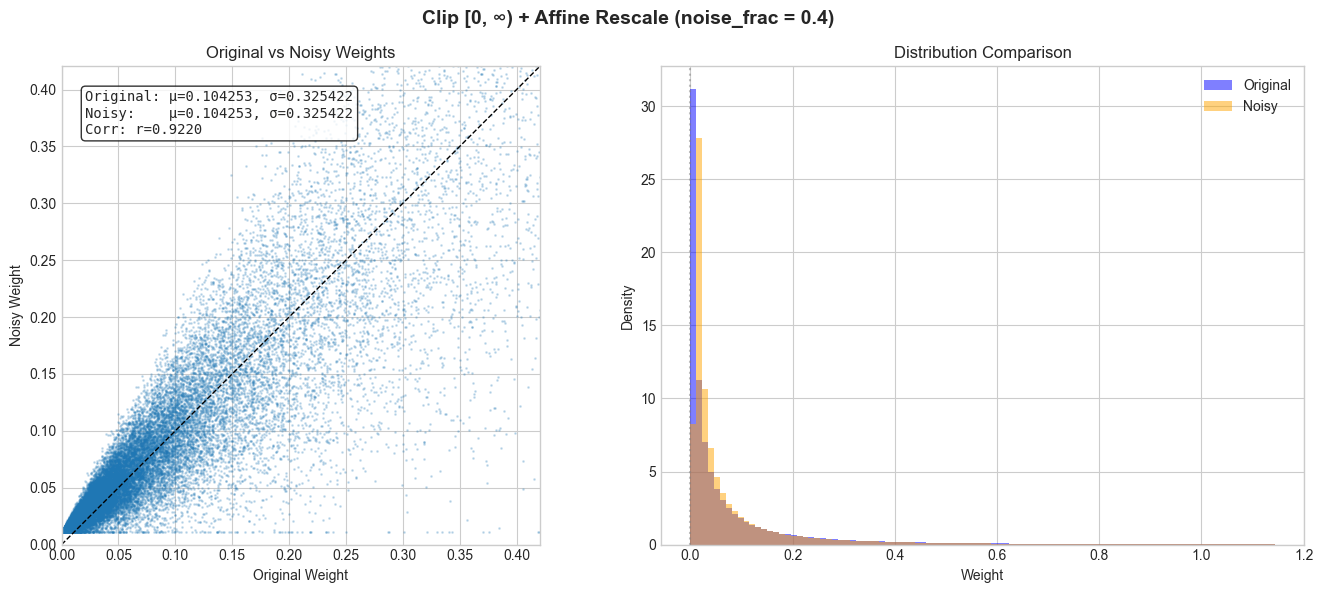

In [5]:
# Visualize: scatter plot and histogram comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
ax = axes[0]
max_points = 50000
if len(weights_nz) > max_points:
    idx = np.random.choice(len(weights_nz), max_points, replace=False)
else:
    idx = np.arange(len(weights_nz))

ax.scatter(weights_nz[idx], noisy_nz[idx], alpha=0.2, s=1)
lims = [min(0, noisy_nz.min()), np.percentile(np.concatenate([weights_nz, noisy_nz]), 95)]
ax.plot(lims, lims, 'k--', linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Original Weight')
ax.set_ylabel('Noisy Weight')
ax.set_aspect('equal')

corr = np.corrcoef(weights_nz, noisy_nz)[0, 1]
stats_text = (
    f"Original: μ={weights_nz.mean():.6f}, σ={weights_nz.std():.6f}\n"
    f"Noisy:    μ={noisy_nz.mean():.6f}, σ={noisy_nz.std():.6f}\n"
    f"Corr: r={corr:.4f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.set_title('Original vs Noisy Weights')

# Histogram comparison - include potential negative values
ax = axes[1]
min_val = min(0, noisy_nz.min())
max_val = np.percentile(np.concatenate([weights_nz, noisy_nz]), 99)
bins = np.linspace(min_val, max_val, 100)
ax.hist(weights_nz, bins=bins, density=True, alpha=0.5, label='Original', color='blue')
ax.hist(noisy_nz, bins=bins, density=True, alpha=0.5, label='Noisy', color='orange')
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Weight')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison')
ax.legend()

plt.suptitle(f'Clip [0, ∞) + Affine Rescale (noise_frac = {noise_frac})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Check for potential issues: negative weights after affine transformation
n_negative = np.sum(noisy_nz < 0)
n_zero = np.sum(noisy_nz == 0)
pct_negative = 100 * n_negative / len(noisy_nz)

print("Post-transformation weight analysis:")
print(f"  Negative weights: {n_negative:,} ({pct_negative:.2f}%)")
print(f"  Zero weights: {n_zero:,}")

if n_negative > 0:
    print(f"\nNote: The affine transformation can produce negative weights.")
    print(f"  This happens because we shift around orig_mean, so weights")
    print(f"  that were clipped to 0 can become: orig_mean - noisy_mean * (orig_std/noisy_std)")
    print(f"  Min negative weight: {noisy_nz[noisy_nz < 0].min():.6f}")

Post-transformation weight analysis:
  Negative weights: 0 (0.00%)
  Zero weights: 0
